# Import necessary dependencies

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

Get the dataset as a dataframe

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

# Data Preprocessing for Date and Time Features

This section of the code focuses on preprocessing the date and time columns in the dataset to create a unified datetime column.

1. **Stripping Whitespace**:
   - `data['date']` and `data['time']`: Any leading and trailing whitespace in the 'date' and 'time' columns is removed using the `.str.strip()` method. This step ensures that the date and time strings are in a consistent format, which is crucial for successful parsing in the next step.

2. **Combining Date and Time Columns**:
   - `data['datetime']`: The 'date' and 'time' columns are concatenated with a space in between to form a single string representing the datetime. This combination is necessary to create a unified datetime object from the separate date and time information.

3. **Converting to DateTime Object**:
   - `pd.to_datetime`: The concatenated string is then converted into a datetime object using Pandas' `to_datetime` function. The `format` parameter is specified as `%d-%b-%y %H:%M:%S`, which matches the format of the input strings, ensuring accurate parsing.
   - The resultant 'datetime' column now provides a more useful and standardized format for any subsequent data analysis or time series modeling, integrating both date and time information into a single, coherent column.

In [5]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

## Extracting Date and Time Components

This part of the code is focused on extracting specific date and time components from the unified 'datetime' column in the data. This process is crucial for detailed time series analysis or for creating features that might be relevant for predictive modeling.

By breaking down the datetime into these individual components, the dataset is enriched with additional features that can provide deeper insights during data exploration or enhance the performance of predictive models.

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

## Finalizing Data Preprocessing for Date and Time Features

This section of the code is dedicated to finalizing the preprocessing steps for the dataset, ensuring it is organized and formatted appropriately for further analysis or modeling.

1. **Sorting Data by DateTime**:
   - The dataset is sorted based on the 'datetime' column using `data.sort_values(by='datetime')`. Sorting by datetime is essential for our time series models, as it ensures the data is in chronological order.

2. **Dropping Unnecessary Columns**:
   - `data.drop(...)`: The original 'date', 'time', 'datetime', and 'type' columns are dropped from the dataset. These columns are no longer needed as we have extracted all the required information into separate features.
   - The `inplace=True` parameter is used to modify the data frame in place, without creating a new one.

3. **Adjusting Feature Order and Data Type**:
   - `order`: A predefined order of features is specified, including the extracted date and time components, feature columns like 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', etc., and the 'label' column.
   - `data = data[order].astype('int32')`: The dataset is then reorganized to follow this specific order, and the data type of all columns is converted to 'int32'. This step ensures that the dataset has a consistent format and is optimized for memory usage, which can be particularly important for large datasets.

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

---
# Data Split
## Training, and Testing Sets
In this project, I utilized both training and test sets. Initially, we designated 80% of the data as the training set and the remaining 20% as an unseen test set. This division ensures that the model has sufficient data for learning during the training process, enhancing its accuracy and robustness while preventing underfitting. Moreover, using 20% of unseen data as an independent test set to evaluate the model's final performance helps in assessing the model's generalization capability on new data, rather than merely measuring its fit on the training data.

In order to compare with our recurrent neural network with Long Short-Term Memory (LSTM), we want to ensure that the training set and unseen test set used in the experiment are consistent. Therefore, we still sort the data set first to split the training set and the test set. However, we then shuffle the order of the training set to improve the model's generalization ability, prevent overfitting, and ensure that the training process is more stable and effective.

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

---
# Data preprocessing 
## Feature Scaling
Feature scaling is a crucial step to enhance the performance and convergence speed of the model. In this part of the code, we performed the following actions:

1. **Selecting Feature Columns**: We created a list of feature columns `feature_columns`, which includes all columns except the 'label' column. This is because the 'label' column is the target variable and should not be considered for feature scaling.

2. **Applying Standard Scaling**: We used StandardScaler from the scikit-learn library to standardize our features. Standard scaling involves subtracting the mean and dividing by the standard deviation for each feature, resulting in features that have a mean of 0 and a standard deviation of 1. This standardization helps in normalizing the range of independent variables or features of data. It is worth noting that in our RNN network with LSTM, we perform `MinMaxScaler` on the data. After trying it, we found that they performed better using different scaling methods.

3. **Transforming Training and Test Data**: The `fit_transform` method is applied to the training data to learn the distribution of the data and transform it. For the test data, we only use the `transform` method, ensuring that we scale the test data using the same parameters (learned from the training data) to avoid data leakage, which is crucial for an accurate evaluation of model performance.

4. **Viewing Information of Transformed Training Data**: Through `X_train.info()`, we can view the information of the scaled training dataset, including the data type and the number of non-null values for each feature. This helps to verify that the scaling process has been correctly executed and ensures that the dataset is ready for model training.

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = StandardScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229755 entries, 0 to 229754
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 9.6 MB


---
# Model Implementation
## Lightweight MLP Model Implementation

In this task, we are developing a lightweight Multi-Layer Perceptron (MLP) network designed for handling various data-driven problems. The objective is to build a model that offers good performance with minimal computational complexity. We will follow key strategies to create an efficient yet powerful model.

## Model Construction
Our implementation involves defining a PyTorch-based MLP model class `LightweightMLP`. This class includes the following main components:
- **Initialization Function** (`__init__` method): We define the input dimension (`input_dim`), hidden layer size (`hidden_size`), and output size (`output_size`). These parameters allow flexibility in adjusting the model’s size and complexity to suit different tasks.
- **First Linear Layer**: A linear layer (`nn.Linear`) that transforms the input dimension to the hidden layer size. This layer acts as the first transformation step in processing the input data.
- **Second Linear Layer**: Another linear layer that maps the hidden layer size to the output size. This layer is crucial for generating the final output of the model.

## Forward Propagation
The `forward` method describes how data flows through the model:
- **Activation in the First Layer**: The input data `x` is passed through the first linear layer, followed by a ReLU (Rectified Linear Unit) activation function. This non-linear activation introduces the ability for the model to learn complex patterns in the data.
- **Final Output Layer**: The activated data is then passed through the second linear layer, which produces the final output of the model.

This design allows the `LightweightMLP` to process a wide range of data efficiently. It's particularly suitable for tasks requiring a balance between model simplicity and the ability to capture intricate data patterns.

## Problem Formulation

Here, the `LightweightMLP` model is utilized to tackle a binary classification problem, aiming to categorize different types of data. The essential aspects of this task are outlined below:

- **Objective**: To predict binary outcomes using the `LightweightMLP` model based on provided input data. The model needs to classify each input into one of two possible categories.

- **Input**: The input $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\}$, where each $\mathbf{x}_i \in \mathbb{R}^{d}$ is a $d$-dimensional feature vector.

- **Output**: The output $\hat{y}$ is a binary value (0 or 1), representing the category of the input. The final layer of the model is designed to output this binary classification.

- **Model**: The `LightweightMLP` is a neural network based on a simple yet effective MLP architecture, making it suitable for various binary classification tasks. It learns through its two linear layers, with a non-linear activation function in between.

- **Loss Function**: Binary Cross-Entropy Loss (BCE) is employed to measure the difference between the predicted values and the actual labels. The loss function is expressed as:
$$L(\mathbf{y}, \hat{\mathbf{y}}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\sigma(\hat{y}_i)) + (1 - y_i) \cdot \log(1 - \sigma(\hat{y}_i)) \right]$$
  Here, $N$ is the number of samples, $y_i$ is the actual class label for sample $i$, $\hat{y}_i$ is the model's predicted output for sample $i$, and $\sigma$ is the Sigmoid function.

- **Optimization Objective**: The goal is to minimize the Binary Cross-Entropy Loss, meaning finding parameters that reduce the loss $L(\mathbf{y}, \hat{\mathbf{y}})$.

In [10]:
class LightweightMLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size):
        super(LightweightMLP, self).__init__()
        
        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        temp = F.relu(self.linear_1(x))
        return self.linear_2(temp)

## MLP Model Instantiation

In this section, we instantiate the `LightweightMLP` model, configuring it with specific hyperparameters for our binary classification task. The setup for the model is detailed below:

1. **Defining Hyperparameters**:
   - `features_num`: This parameter represents the number of input features in our dataset, determined by the shape of the training data, `X_train.shape[1]`. It sets the input dimension for the MLP model.
   - `hidden_neurons_num`: We have chosen to use 512 neurons in the hidden layer of the MLP. This number strikes a balance between model complexity and computational efficiency, providing sufficient capacity to learn from the data.
   - `output_neurons_num`: For binary classification, the output layer needs only one neuron. This neuron will output the probability indicating the likelihood of the input data belonging to one of the classes.

2. **Model Initialization**:
   - We initialize the `LightweightMLP` model using these defined hyperparameters. This step constructs a model instance that is tailored to our specific classification task.
   - The initialized model is then moved to the designated computing device using `.to(device)`. This operation ensures that the model training and inference will leverage the appropriate hardware, such as a GPU if available, for enhanced computational performance.


In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1

model = LightweightMLP(features_num, hidden_neurons_num, output_neurons_num).to(device)

## Computing Class Weights to Balance the Dataset

In our task, the occurrence of attacks (positive samples) in network data is typically less frequent compared to normal (negative samples) traffic, leading to an issue of class imbalance in our dataset. To address this issue and enhance the model's performance in detecting attacks, we have adopted a method of computing class weights.

1. **Calculating Weights Using `compute_class_weight`**:
   - We calculate weights for each category using the `compute_class_weight` function from scikit-learn. These weights are determined based on their frequency of occurrence in the training set (`y_train`).
   - Setting `class_weight='balanced'` ensures that less frequently occurring categories (in our case, attack data) are assigned higher weights.
   - `classes=np.unique(y_train)`: This ensures that the weight calculation encompasses all unique class labels.

2. **Converting to PyTorch Tensor and Assigning to the Device**:
   - The calculated class weights are then converted into a PyTorch tensor, as our model is trained using PyTorch.

By this approach, we adjust the model's handling of class imbalance, thereby making it more effective in detecting potential attacks in IoT device network data. This helps to increase the model's accuracy and sensitivity in detecting attack categories that occur less frequently.

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

## Setting Up the Loss Function and Optimizer

In this part of the code, we configure the loss function and optimizer for our neural network model, which is crucial for the model's training process.

1. **Defining Custom Weights for Loss Function**:
   - `weights`: We create a tensor `weights` with two elements. The first element is for the negative class (normal data), set to 1. The second element is the computed weight for the positive class (attack data), derived from `class_weights[1]`. This approach emphasizes the importance of correctly classifying the less frequent positive class in our dataset.
   - The tensor `weights` is defined with data type `torch.float`, ensuring compatibility with PyTorch operations.

2. **Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss)**:
   - `criterion`: We use the `nn.BCEWithLogitsLoss` loss function from PyTorch, which combines a Sigmoid layer and the BCELoss in one single class. This is particularly useful for binary classification tasks.
   - The argument `torch.FloatTensor([weights[1] / weights[0]])` is passed to the loss function, which adjusts the loss calculation to account for the imbalance between the positive and negative classes.

3. **Optimizer Configuration**:
   - `optimizer`: We use the Adam optimizer, a popular choice for training deep learning models. It's defined with `optim.Adam(model.parameters(), lr=0.0001)`, where `lr=0.0001` specifies a learning rate of 0.0001. This learning rate determines the step size during the gradient descent optimization process.

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

## Preparing the Training Data

In this part of our implementation, we are setting up the training data for our neural network, focusing on optimizing the data format for batch processing during training. This process includes converting the training data into PyTorch tensors, creating a dataset, and then forming a data loader to facilitate efficient batch processing.

1. **Setting Batch Size**:
   - `batch_size`: We have chosen a batch size of 128. The batch size is an important hyperparameter in neural network training, dictating the number of samples that will be passed through the network before an update to the model parameters is made.

2. **Converting Training Data to PyTorch Tensors**:
   - `X_train_tensor`: The feature data from our training set (`X_train`) is converted into a PyTorch tensor. We use the `.float()` method to ensure that the data is in a floating-point format, as required for most neural network operations in PyTorch.
   - `y_train_tensor`: The target values (`y_train`) are also converted into a PyTorch tensor in a similar fashion.
   - Both tensors are moved to the specified computing device (like a GPU, if available) using `.to(device)` to ensure efficient computation.

3. **Creating TensorDataset and DataLoader**:
   - `train_dataset`: A `TensorDataset` is created with `X_train_tensor` and `y_train_tensor`. `TensorDataset` provides a convenient way of pairing the feature and target tensors together.
   - `train_loader`: We then create a `DataLoader` from the `train_dataset`. This DataLoader facilitates efficient iteration over the dataset in batches of the specified size (`batch_size`, which is 128 in this case). The `shuffle=True` parameter indicates that the data will be shuffled at the beginning of each epoch. Shuffling the data is beneficial as it prevents the model from learning any order-based dependencies and aids in generalizing better by ensuring that each batch is a good representation of the overall dataset.

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Training Loop

This section of the code outlines the training process of the neural network model over a specified number of epochs. 

1. **Setting Up the Training**:
   - `num_epochs`: The total number of epochs (iterations over the entire dataset) is set to 100. An epoch is one complete cycle through the training data.
   - `loss_list` and `acc_list`: These lists are initialized to store the loss and accuracy values for each epoch, allowing for tracking the model's performance over time.

2. **Training Loop**:
   - The loop iterates over the number of epochs specified. In each epoch, the model's parameters are updated based on the training data.
   - `model.train()`: This sets the model to training mode, enabling certain layers to function appropriately during training.
   - `running_loss` and `running_accuracy`: Variables initialized to accumulate the loss and accuracy for each batch within an epoch.

3. **Batch Processing Within Each Epoch**:
   - The inner loop iterates over each batch of data in `train_loader`.
   - **Forward Pass (FP)**: The model computes the output (`outputs`) for a batch of inputs.
   - **Loss Computation**: The loss between the outputs and the ground truth labels is calculated using the criterion defined earlier.
   - **Backpropagation and Optimization (BP)**: The gradients are computed (`loss.backward()`) and the optimizer updates the model parameters (`optimizer.step()`).

4. **Calculating Performance Indicators**:
   - After processing each batch, the model's predictions and loss are used to calculate the running accuracy and loss.
   - These values are then averaged over all batches to obtain the epoch's average loss and accuracy.

5. **Logging and Progress Update**:
   - At the end of each epoch, the average loss and accuracy are printed, and the progress bar is updated.

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')
    pbar.update(1)
pbar.reset()

  1%|          | 1/100 [00:02<03:18,  2.01s/it]

Epoch [1/100], Loss: 0.6589625979940281, Accuracy: 0.8319567820504111


  2%|▏         | 2/100 [00:03<03:11,  1.95s/it]

Epoch [2/100], Loss: 0.5343533533794317, Accuracy: 0.84107916779899


  3%|▎         | 3/100 [00:05<03:08,  1.94s/it]

Epoch [3/100], Loss: 0.5067386922157954, Accuracy: 0.8470946707203841


  4%|▍         | 4/100 [00:07<03:05,  1.94s/it]

Epoch [4/100], Loss: 0.4873922459635729, Accuracy: 0.8601853542473447


  5%|▌         | 5/100 [00:09<03:03,  1.93s/it]

Epoch [5/100], Loss: 0.4739059772498667, Accuracy: 0.8766465396199923


  6%|▌         | 6/100 [00:11<03:01,  1.93s/it]

Epoch [6/100], Loss: 0.462323995771373, Accuracy: 0.8903956691464546


  7%|▋         | 7/100 [00:13<02:59,  1.93s/it]

Epoch [7/100], Loss: 0.45195247949353995, Accuracy: 0.899510588638268


  8%|▊         | 8/100 [00:15<02:57,  1.93s/it]

Epoch [8/100], Loss: 0.443771036605275, Accuracy: 0.9053686986208302


  9%|▉         | 9/100 [00:17<02:54,  1.92s/it]

Epoch [9/100], Loss: 0.43667356919062955, Accuracy: 0.9089776960617796


 10%|█         | 10/100 [00:19<02:51,  1.91s/it]

Epoch [10/100], Loss: 0.4303876812312863, Accuracy: 0.9120454075797723


 11%|█         | 11/100 [00:21<02:50,  1.91s/it]

Epoch [11/100], Loss: 0.42572751530264696, Accuracy: 0.9139258073465136


 12%|█▏        | 12/100 [00:23<02:55,  2.00s/it]

Epoch [12/100], Loss: 0.42140608517167016, Accuracy: 0.9155581221550377


 13%|█▎        | 13/100 [00:25<02:53,  1.99s/it]

Epoch [13/100], Loss: 0.4179911896068537, Accuracy: 0.9167125611454583


 14%|█▍        | 14/100 [00:27<02:51,  1.99s/it]

Epoch [14/100], Loss: 0.41453143550868093, Accuracy: 0.9181042572525308


 15%|█▌        | 15/100 [00:29<02:47,  1.97s/it]

Epoch [15/100], Loss: 0.41187581858000183, Accuracy: 0.9189179730846752


 16%|█▌        | 16/100 [00:31<02:44,  1.95s/it]

Epoch [16/100], Loss: 0.40925746180165934, Accuracy: 0.9198927265212764


 17%|█▋        | 17/100 [00:33<02:43,  1.97s/it]

Epoch [17/100], Loss: 0.40701545236476533, Accuracy: 0.920706265427905


 18%|█▊        | 18/100 [00:35<02:40,  1.96s/it]

Epoch [18/100], Loss: 0.40528080653491566, Accuracy: 0.921028871413366


 19%|█▉        | 19/100 [00:37<02:37,  1.94s/it]

Epoch [19/100], Loss: 0.40314776751982684, Accuracy: 0.9220781458772109


 20%|██        | 20/100 [00:38<02:35,  1.95s/it]

Epoch [20/100], Loss: 0.40113890100824146, Accuracy: 0.9224432139864575


 21%|██        | 21/100 [00:40<02:33,  1.95s/it]

Epoch [21/100], Loss: 0.39987702120354673, Accuracy: 0.922895683300496


 22%|██▏       | 22/100 [00:42<02:31,  1.94s/it]

Epoch [22/100], Loss: 0.39820606202618064, Accuracy: 0.9235924159816111


 23%|██▎       | 23/100 [00:44<02:30,  1.96s/it]

Epoch [23/100], Loss: 0.3969907199491243, Accuracy: 0.9240668240596055


 24%|██▍       | 24/100 [00:46<02:29,  1.96s/it]

Epoch [24/100], Loss: 0.3955271176727772, Accuracy: 0.9245161794845664


 25%|██▌       | 25/100 [00:48<02:26,  1.96s/it]

Epoch [25/100], Loss: 0.39443209379783656, Accuracy: 0.9252858408632834


 26%|██▌       | 26/100 [00:50<02:23,  1.95s/it]

Epoch [26/100], Loss: 0.3933994734400891, Accuracy: 0.9255767417963178


 27%|██▋       | 27/100 [00:52<02:21,  1.94s/it]

Epoch [27/100], Loss: 0.3923724725109919, Accuracy: 0.925663966075594


 28%|██▊       | 28/100 [00:54<02:23,  1.99s/it]

Epoch [28/100], Loss: 0.3912183256651906, Accuracy: 0.9264789203863487


 29%|██▉       | 29/100 [00:56<02:21,  2.00s/it]

Epoch [29/100], Loss: 0.39036804402212577, Accuracy: 0.9269435621758725


 30%|███       | 30/100 [00:58<02:19,  1.99s/it]

Epoch [30/100], Loss: 0.3895702263255189, Accuracy: 0.9276843493104151


 31%|███       | 31/100 [01:00<02:16,  1.97s/it]

Epoch [31/100], Loss: 0.38883326444290467, Accuracy: 0.9275316625903028


 32%|███▏      | 32/100 [01:02<02:13,  1.96s/it]

Epoch [32/100], Loss: 0.38799770423482444, Accuracy: 0.9282882668659557


 33%|███▎      | 33/100 [01:04<02:10,  1.95s/it]

Epoch [33/100], Loss: 0.38734879872995615, Accuracy: 0.9285978157483525


 34%|███▍      | 34/100 [01:06<02:08,  1.95s/it]

Epoch [34/100], Loss: 0.38671215491046745, Accuracy: 0.9285852894218357


 35%|███▌      | 35/100 [01:08<02:07,  1.96s/it]

Epoch [35/100], Loss: 0.38595380188630085, Accuracy: 0.9288554900695246


 36%|███▌      | 36/100 [01:10<02:04,  1.95s/it]

Epoch [36/100], Loss: 0.38559367128267985, Accuracy: 0.9295248700659012


 37%|███▋      | 37/100 [01:12<02:01,  1.93s/it]

Epoch [37/100], Loss: 0.38496212777885236, Accuracy: 0.9296732044183256


 38%|███▊      | 38/100 [01:14<01:59,  1.92s/it]

Epoch [38/100], Loss: 0.3844901953866123, Accuracy: 0.9302128980116403


 39%|███▉      | 39/100 [01:16<01:56,  1.91s/it]

Epoch [39/100], Loss: 0.3839062487340223, Accuracy: 0.9299782240075186


 40%|████      | 40/100 [01:17<01:54,  1.91s/it]

Epoch [40/100], Loss: 0.3834713367182932, Accuracy: 0.9308612238716398


 41%|████      | 41/100 [01:19<01:52,  1.90s/it]

Epoch [41/100], Loss: 0.3831734687164505, Accuracy: 0.9304513936069027


 42%|████▏     | 42/100 [01:21<01:50,  1.90s/it]

Epoch [42/100], Loss: 0.38278584904682234, Accuracy: 0.9310565496410536


 43%|████▎     | 43/100 [01:23<01:48,  1.90s/it]

Epoch [43/100], Loss: 0.38223779019623316, Accuracy: 0.9310356724301923


 44%|████▍     | 44/100 [01:25<01:46,  1.90s/it]

Epoch [44/100], Loss: 0.3819952055223956, Accuracy: 0.9312574662567656


 45%|████▌     | 45/100 [01:27<01:43,  1.89s/it]

Epoch [45/100], Loss: 0.3817029689296706, Accuracy: 0.9311314245193287


 46%|████▌     | 46/100 [01:29<01:42,  1.89s/it]

Epoch [46/100], Loss: 0.3815016166791208, Accuracy: 0.9313144008877415


 47%|████▋     | 47/100 [01:31<01:40,  1.89s/it]

Epoch [47/100], Loss: 0.38118954128309607, Accuracy: 0.9312969914169894


 48%|████▊     | 48/100 [01:33<01:38,  1.89s/it]

Epoch [48/100], Loss: 0.3808884177534098, Accuracy: 0.9317929844079081


 49%|████▉     | 49/100 [01:34<01:36,  1.89s/it]

Epoch [49/100], Loss: 0.3806445840458281, Accuracy: 0.9317616332065132


 50%|█████     | 50/100 [01:37<01:36,  1.94s/it]

Epoch [50/100], Loss: 0.38052700930693856, Accuracy: 0.9317790426772653


 51%|█████     | 51/100 [01:38<01:35,  1.94s/it]

Epoch [51/100], Loss: 0.38017039194345414, Accuracy: 0.9319366125416129


 52%|█████▏    | 52/100 [01:40<01:33,  1.94s/it]

Epoch [52/100], Loss: 0.3800557657366429, Accuracy: 0.9317054062776005


 53%|█████▎    | 53/100 [01:42<01:30,  1.93s/it]

Epoch [53/100], Loss: 0.3798931130934653, Accuracy: 0.9318930888647327


 54%|█████▍    | 54/100 [01:44<01:28,  1.92s/it]

Epoch [54/100], Loss: 0.37980228016154477, Accuracy: 0.9321188812079625


 55%|█████▌    | 55/100 [01:46<01:26,  1.92s/it]

Epoch [55/100], Loss: 0.37944697952927375, Accuracy: 0.9318798548361529


 56%|█████▌    | 56/100 [01:48<01:24,  1.92s/it]

Epoch [56/100], Loss: 0.37934617216144845, Accuracy: 0.932145526190638


 57%|█████▋    | 57/100 [01:50<01:22,  1.92s/it]

Epoch [57/100], Loss: 0.3792824477348407, Accuracy: 0.9322315119913038


 58%|█████▊    | 58/100 [01:52<01:20,  1.91s/it]

Epoch [58/100], Loss: 0.37918369328258883, Accuracy: 0.9322367489865707


 59%|█████▉    | 59/100 [01:54<01:18,  1.91s/it]

Epoch [59/100], Loss: 0.3790428718254098, Accuracy: 0.9325677058563762


 60%|██████    | 60/100 [01:56<01:16,  1.90s/it]

Epoch [60/100], Loss: 0.3788081816616641, Accuracy: 0.9325717043730326


 61%|██████    | 61/100 [01:58<01:14,  1.90s/it]

Epoch [61/100], Loss: 0.37868547878512665, Accuracy: 0.9322973282831715


 62%|██████▏   | 62/100 [01:59<01:12,  1.90s/it]

Epoch [62/100], Loss: 0.3787618178301326, Accuracy: 0.9326072310165999


 63%|██████▎   | 63/100 [02:01<01:10,  1.90s/it]

Epoch [63/100], Loss: 0.3785436969556159, Accuracy: 0.9322581569739793


 64%|██████▍   | 64/100 [02:03<01:08,  1.89s/it]

Epoch [64/100], Loss: 0.37852519389991596, Accuracy: 0.9324970064202731


 65%|██████▌   | 65/100 [02:05<01:06,  1.89s/it]

Epoch [65/100], Loss: 0.3785921879018192, Accuracy: 0.9325675289308604


 66%|██████▌   | 66/100 [02:07<01:04,  1.89s/it]

Epoch [66/100], Loss: 0.37830754447542664, Accuracy: 0.9326451638471817


 67%|██████▋   | 67/100 [02:09<01:02,  1.89s/it]

Epoch [67/100], Loss: 0.3782954754959068, Accuracy: 0.9326719857553729


 68%|██████▊   | 68/100 [02:11<01:00,  1.89s/it]

Epoch [68/100], Loss: 0.378230208535181, Accuracy: 0.9325847614760967


 69%|██████▉   | 69/100 [02:13<00:58,  1.89s/it]

Epoch [69/100], Loss: 0.37822287760334294, Accuracy: 0.9325419455012796


 70%|███████   | 70/100 [02:15<00:56,  1.89s/it]

Epoch [70/100], Loss: 0.37831473794183945, Accuracy: 0.9327160402088004


 71%|███████   | 71/100 [02:16<00:54,  1.89s/it]

Epoch [71/100], Loss: 0.37821406348934966, Accuracy: 0.9326067002400525


 72%|███████▏  | 72/100 [02:18<00:52,  1.89s/it]

Epoch [72/100], Loss: 0.37798333055101224, Accuracy: 0.9325845845505809


 73%|███████▎  | 73/100 [02:20<00:50,  1.88s/it]

Epoch [73/100], Loss: 0.3782384041155963, Accuracy: 0.9323674969427271


 74%|███████▍  | 74/100 [02:22<00:49,  1.88s/it]

Epoch [74/100], Loss: 0.37830198321082315, Accuracy: 0.9324715999162081


 75%|███████▌  | 75/100 [02:24<00:47,  1.88s/it]

Epoch [75/100], Loss: 0.3780780274383765, Accuracy: 0.9322369259120864


 76%|███████▌  | 76/100 [02:26<00:45,  1.88s/it]

Epoch [76/100], Loss: 0.3780072027482586, Accuracy: 0.9323629676495233


 77%|███████▋  | 77/100 [02:28<00:43,  1.88s/it]

Epoch [77/100], Loss: 0.3781894616788989, Accuracy: 0.9322456306474625


 78%|███████▊  | 78/100 [02:30<00:41,  1.88s/it]

Epoch [78/100], Loss: 0.3779482872100191, Accuracy: 0.932793498199606


 79%|███████▉  | 79/100 [02:31<00:39,  1.89s/it]

Epoch [79/100], Loss: 0.37785519269023227, Accuracy: 0.9323098546096882


 80%|████████  | 80/100 [02:33<00:37,  1.89s/it]

Epoch [80/100], Loss: 0.37804276683053417, Accuracy: 0.9325281806961524


 81%|████████  | 81/100 [02:35<00:35,  1.89s/it]

Epoch [81/100], Loss: 0.37791648552777374, Accuracy: 0.9324333132345948


 82%|████████▏ | 82/100 [02:37<00:33,  1.89s/it]

Epoch [82/100], Loss: 0.37803324170009983, Accuracy: 0.9326154049754286


 83%|████████▎ | 83/100 [02:39<00:32,  1.88s/it]

Epoch [83/100], Loss: 0.3780310833504201, Accuracy: 0.9326895721516407


 84%|████████▍ | 84/100 [02:41<00:30,  1.88s/it]

Epoch [84/100], Loss: 0.3780305621233607, Accuracy: 0.9322929759154834


 85%|████████▌ | 85/100 [02:43<00:28,  1.90s/it]

Epoch [85/100], Loss: 0.3778368917185475, Accuracy: 0.9325062419321966


 86%|████████▌ | 86/100 [02:45<00:26,  1.91s/it]

Epoch [86/100], Loss: 0.377848387032255, Accuracy: 0.9325320022872932


 87%|████████▋ | 87/100 [02:47<00:24,  1.90s/it]

Epoch [87/100], Loss: 0.37783140210300503, Accuracy: 0.9325499425345926


 88%|████████▊ | 88/100 [02:49<00:23,  1.93s/it]

Epoch [88/100], Loss: 0.3780273445127153, Accuracy: 0.9325238283284644


 89%|████████▉ | 89/100 [02:51<00:21,  1.97s/it]

Epoch [89/100], Loss: 0.37786010286187516, Accuracy: 0.932389435706683


 90%|█████████ | 90/100 [02:53<00:20,  2.06s/it]

Epoch [90/100], Loss: 0.3780497396549528, Accuracy: 0.9324458395611115


 91%|█████████ | 91/100 [02:55<00:18,  2.05s/it]

Epoch [91/100], Loss: 0.37788670224940146, Accuracy: 0.9325018895645085


 92%|█████████▏| 92/100 [02:57<00:16,  2.03s/it]

Epoch [92/100], Loss: 0.37780431663013797, Accuracy: 0.9326286390040085


 93%|█████████▎| 93/100 [02:59<00:14,  2.00s/it]

Epoch [93/100], Loss: 0.3779193831445841, Accuracy: 0.9324580120365967


 94%|█████████▍| 94/100 [03:01<00:11,  1.99s/it]

Epoch [94/100], Loss: 0.3778271822369695, Accuracy: 0.9325454132413887


 95%|█████████▌| 95/100 [03:03<00:09,  1.98s/it]

Epoch [95/100], Loss: 0.3780514811315551, Accuracy: 0.9323363226668478


 96%|█████████▌| 96/100 [03:05<00:07,  1.99s/it]

Epoch [96/100], Loss: 0.37774858986269555, Accuracy: 0.9326239327852889


 97%|█████████▋| 97/100 [03:07<00:05,  1.99s/it]

Epoch [97/100], Loss: 0.37780926371914747, Accuracy: 0.9323840217859004


 98%|█████████▊| 98/100 [03:09<00:03,  1.97s/it]

Epoch [98/100], Loss: 0.378059886691905, Accuracy: 0.9321718173222818


 99%|█████████▉| 99/100 [03:11<00:01,  1.95s/it]

Epoch [99/100], Loss: 0.3778098578416848, Accuracy: 0.9326979230359853


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.3780260535654302, Accuracy: 0.9321970469008312


## Plotting Training Loss and Accuracy

This section of the code is focused on visualizing the training performance of the model in terms of loss and accuracy across epochs.

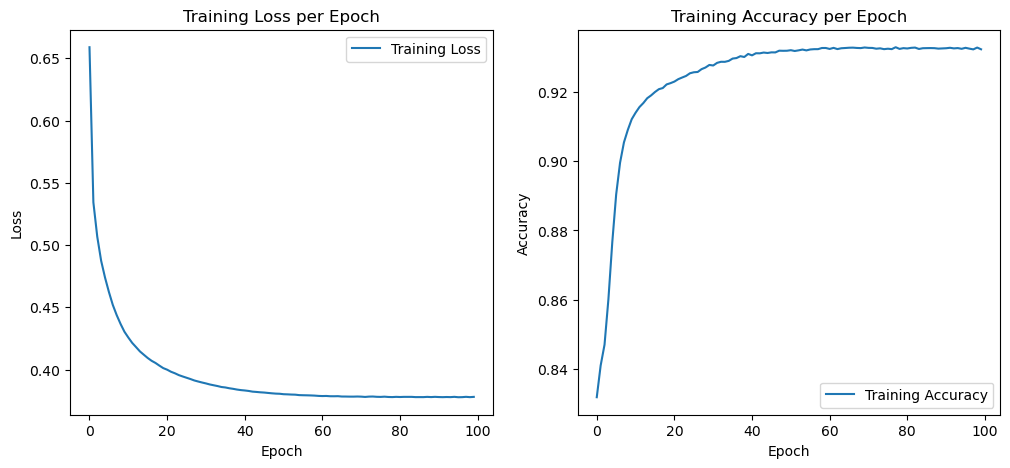

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluating the Model on the Test Dataset

This code section describes the process of evaluating the trained neural network model on the test dataset to assess its performance and generalization ability.

1. **Preparing Test Data**:
   - `X_test_tensor`: The test feature data (`X_test`) is converted into a PyTorch tensor, ensuring it is in the correct format (floating point) and dimensionality for the model.

2. **Model Evaluation Mode**:
   - `model.eval()`: This command sets the model to evaluation mode, disabling certain layers that are only active during training.

3. **Generating Predictions**:
   - The model is used to compute the output for the test data (`outputs`).
   - `torch.no_grad()`: Ensures that no gradient calculations are performed, which is necessary for evaluation as it saves memory and computations.
   - `probabilities`: The raw outputs from the model are passed through a sigmoid function to convert them into probabilities.
   - `predictions`: Probabilities are converted into binary predictions based on a threshold of 0.5.

4. **Calculating Performance Metrics**:
   - Various metrics such as accuracy, precision, recall, and F1 score are computed to measure the model's performance. These metrics provide insights into how well the model is performing, particularly in terms of identifying positive cases (attacks) correctly.

5. **Displaying Evaluation Results**:
   - The performance metrics are printed, giving a comprehensive view of the model's effectiveness on the test dataset.

This evaluation step is crucial for understanding the real-world applicability of the model in classifying IoT device data, specifically in distinguishing between normal operations and potential security threats.

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs).squeeze()
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.9021222514319539 , Precision:  0.9060283687943262 , Recall:  0.32292719919110213 , F1:  0.4761461051062243
